In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from preprocessing_utils import *
import datetime


import correlation

%load_ext autoreload
%autoreload 2

In [2]:
sim_series = 'wrf_prcp'

In [3]:
# Parameters
start="1900-01-01"
end="2020-12-31"

# TRAIN_PATH = "../../data/pickle/df_stations_all_nonzero_extended.pkl"
TRAIN_PATH = '../../data/idaweb/observations_enriched_WRF_reduced.pkl'


st = (pd.read_pickle(TRAIN_PATH)
#     .pipe(drop_df_NaNs, series='Prec') # Drop NaNs
#     .pipe(clip_time_period, start, end) # Clip data temporally 
)

In [4]:
st['occurrence'] = st.apply(correlation.occurrence, axis=1)

In [4]:
st['bias'] = st[sim_series] - st['Prec']

st.set_index('Date', inplace=True)
st['year'] = st.index.year
st['month'] = st.index.month
st['season'] = st.apply(correlation.season, axis=1)

st.reset_index(inplace=True)

In [5]:
seasons = correlation.list_seasons(st)

In [6]:
# Aggregate Prec by Station & Month
st.groupby(['Station','month']).sum()[['Prec']].reset_index()

,Station,month,Prec
0,Arki,1,260.1
1,Arki,2,376.2
2,Arki,3,481.9
3,Arki,4,147.6
4,Arki,5,357.9
...,...,...,...
691,Theog,8,1749.0
692,Theog,9,773.0
693,Theog,10,322.0
694,Theog,11,59.0


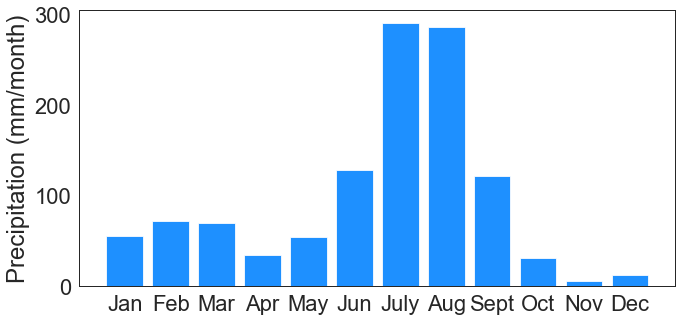

In [7]:
correlation.plot_monthly_timeseries(st)

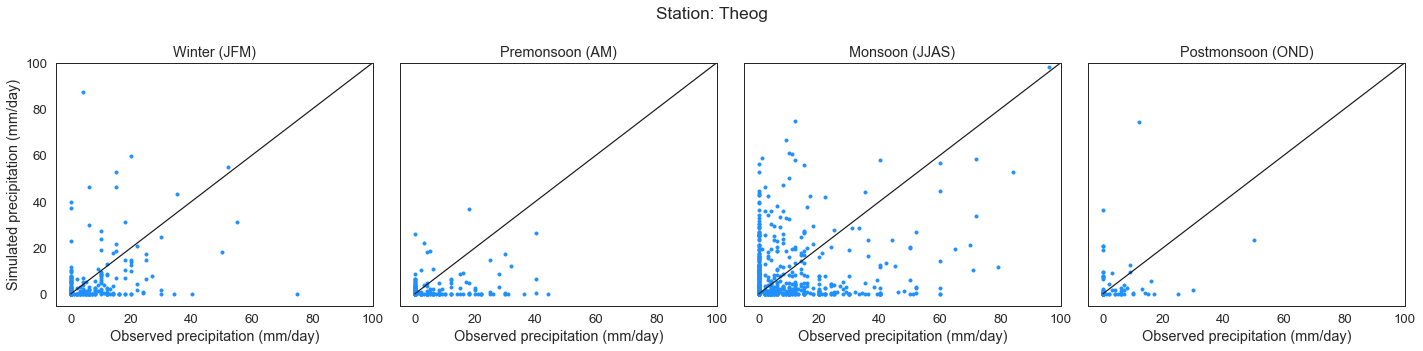

,Prec,wrf_prcp,bias
Prec,1.000000,0.240297,-0.669242
wrf_prcp,0.240297,1.000000,0.560456
bias,-0.669242,0.560456,1.000000


In [8]:
correlation.plot_seasonal_correlation_per_station(st)

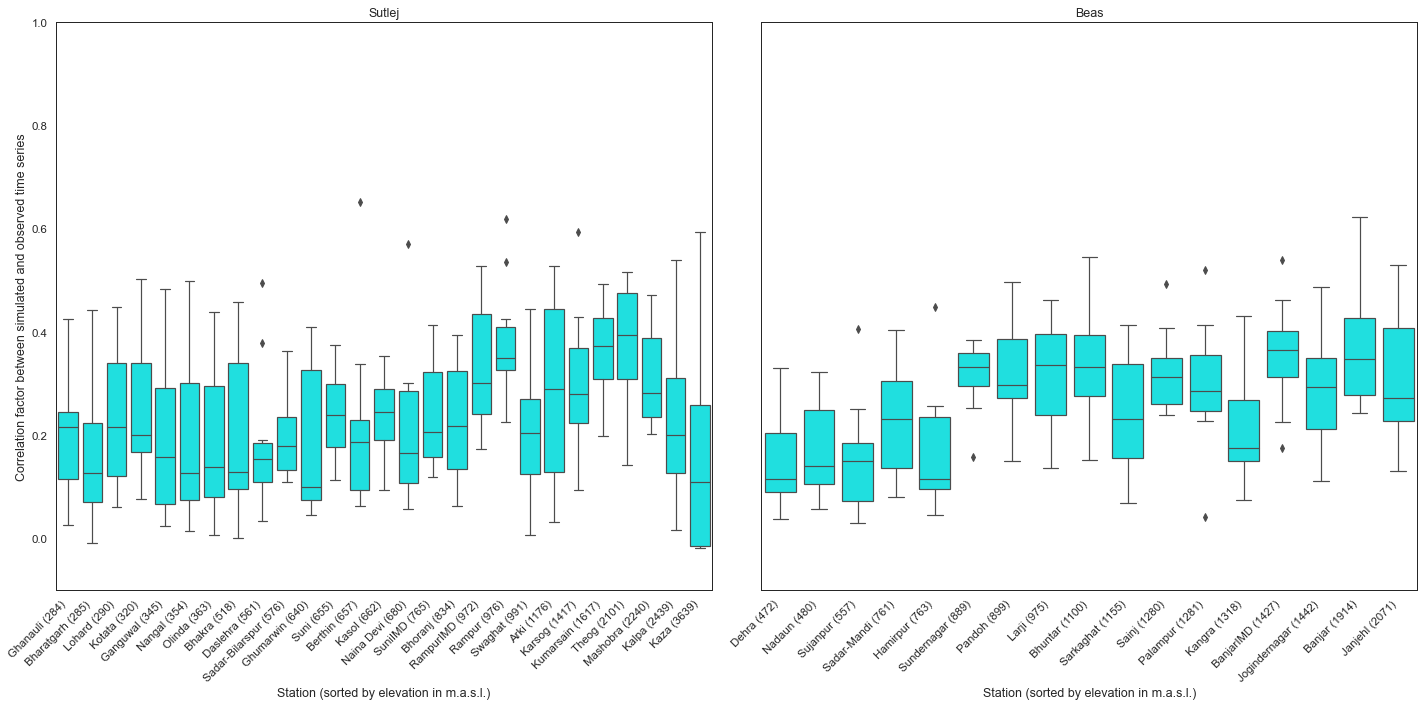

In [9]:
correlation.plot_correlation_per_elevation(st)

### Correlation plots

In [10]:
corr_series = ['bias']

st_pivot = st.pivot(index='Date',
        columns='Station',
        values=corr_series)

st_corr = st_pivot.corr(method='spearman')

In [11]:
# st_corr.reset_index(inplace=True)
# st_corr = st_corr[st_corr['level_0']=='Prec']['wrf_prcp'].copy()
# st_corr.set_index(st_corr.columns.values, inplace=True)

In [12]:
st_corr = st_corr.reset_index().set_index('Station').drop(columns=['level_0'])

/Users/marron31/miniconda3/envs/upperindus/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


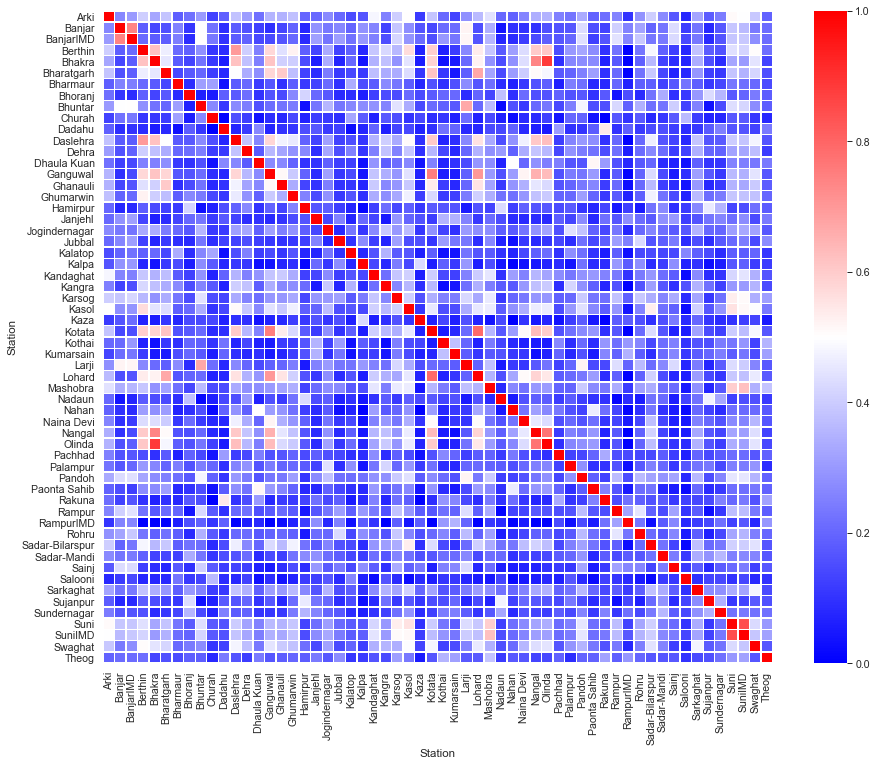

In [13]:
correlation.plot_heatmap(st_corr)

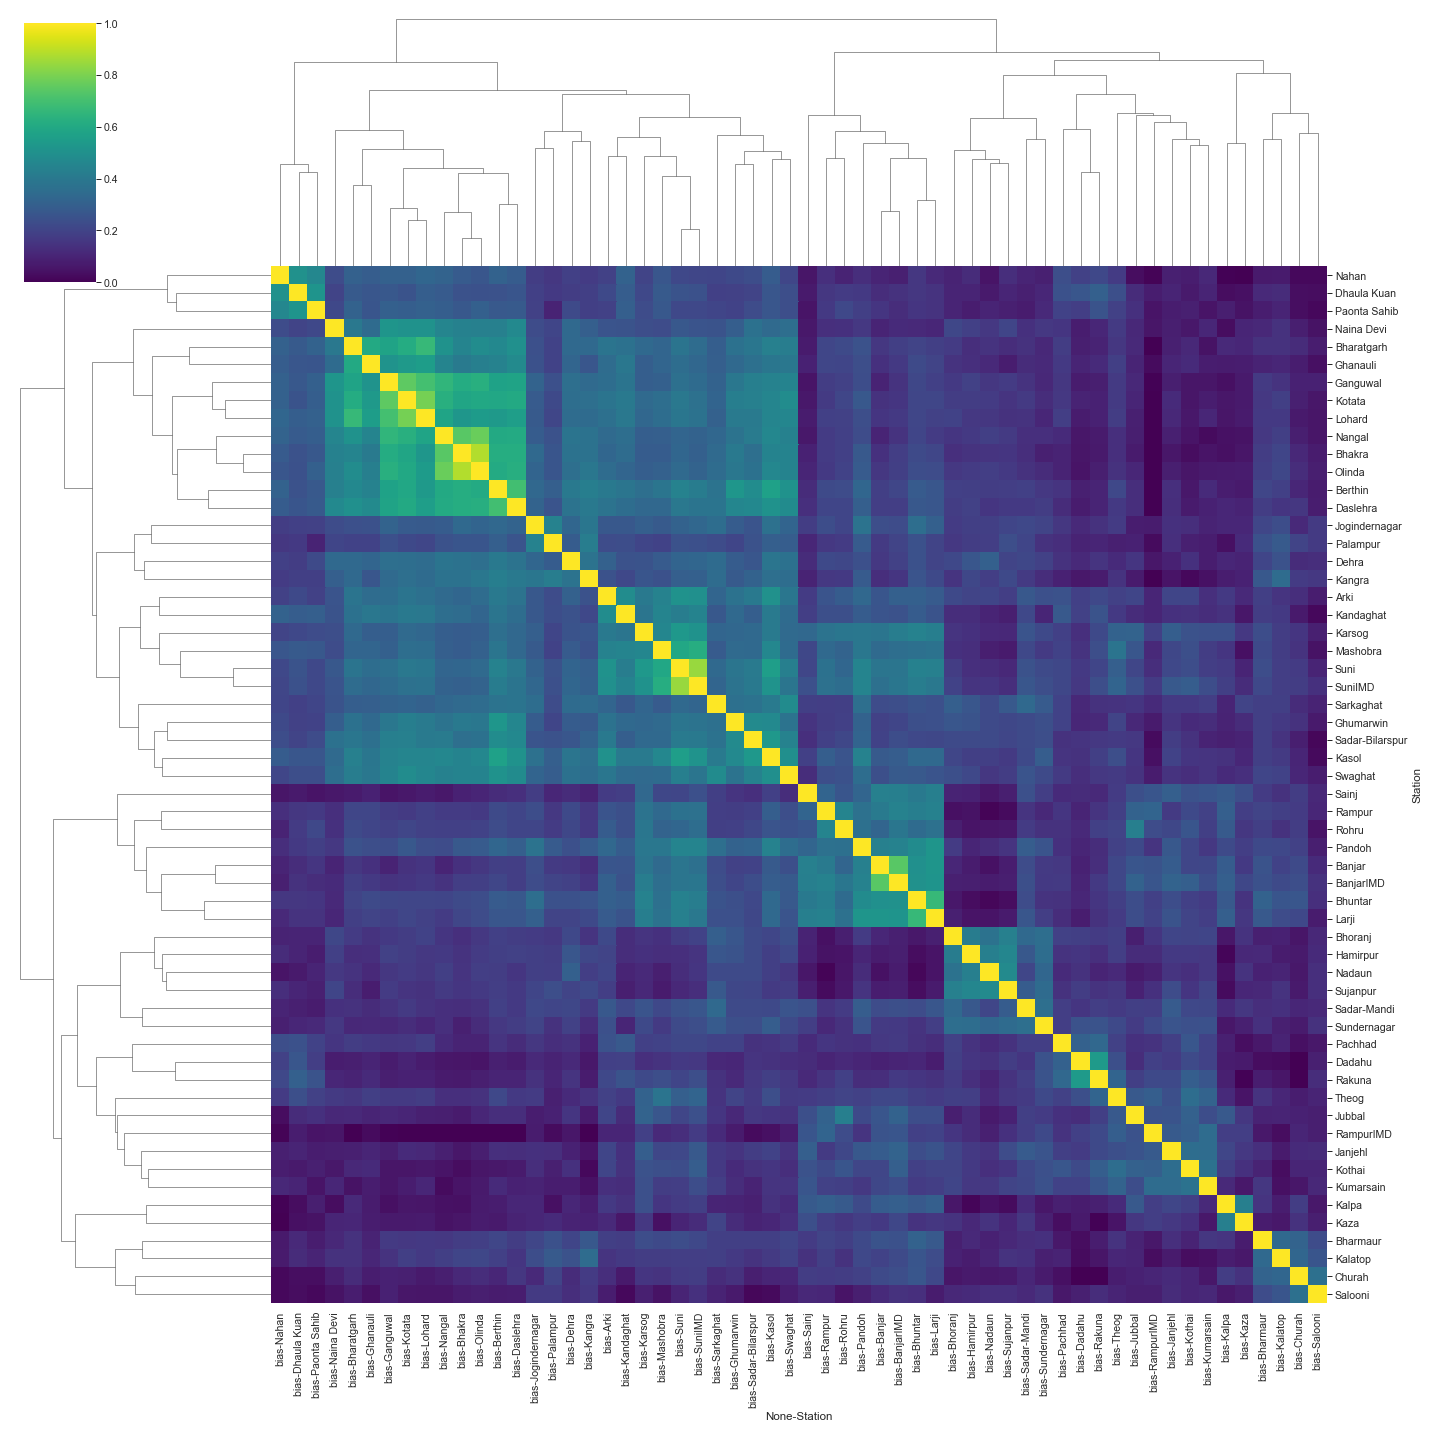

In [14]:
correlation.plot_clustermap(st_corr)

In [15]:
dist_list = ['Z']

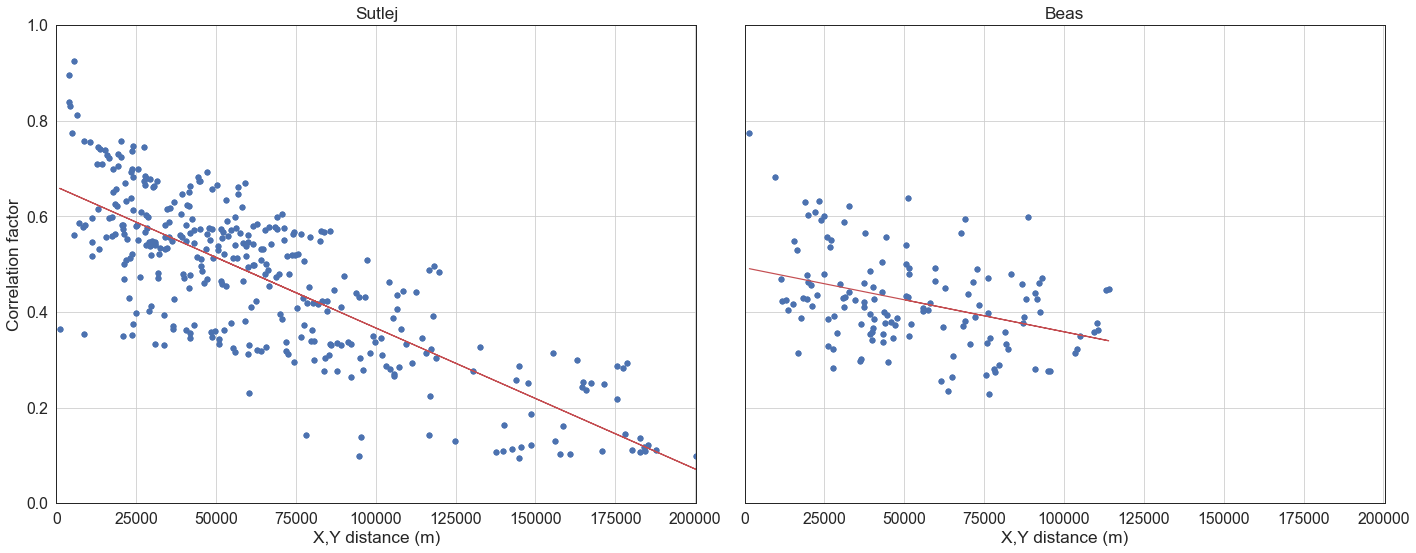

occurrence-['X', 'Y']


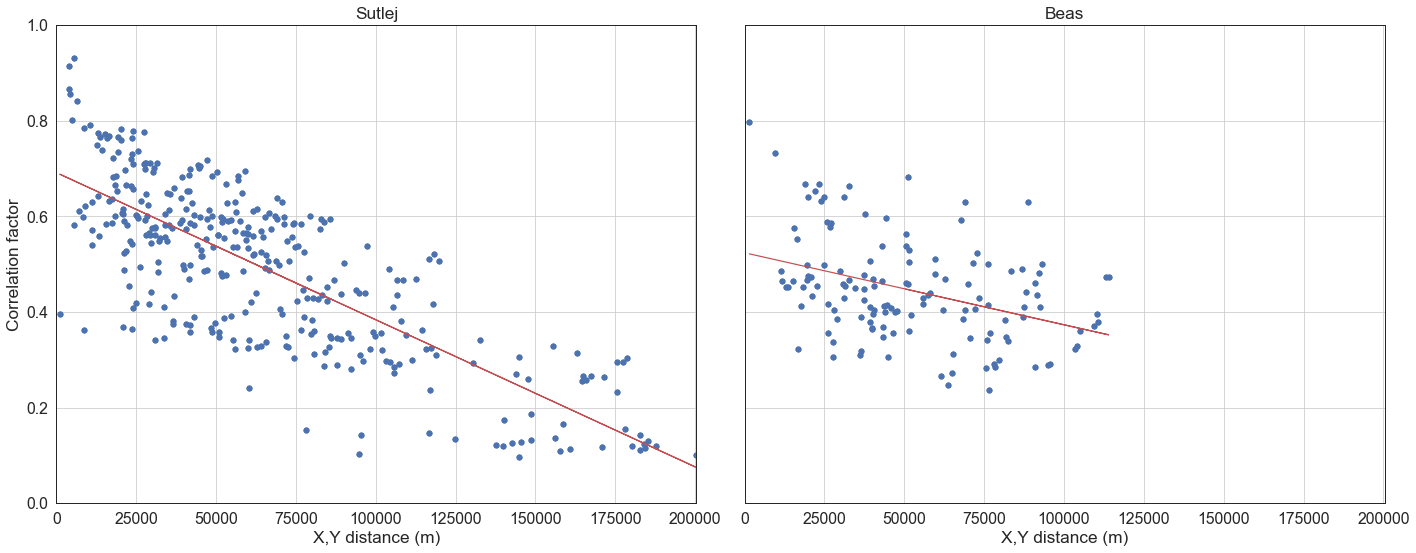

Prec-['X', 'Y']


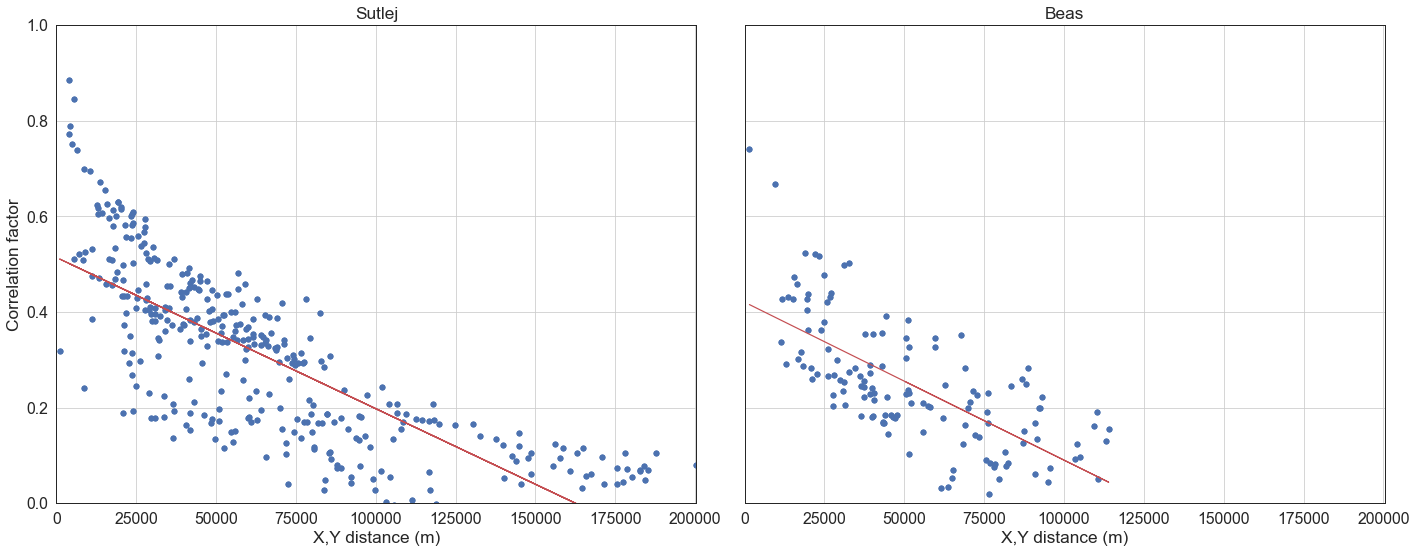

bias-['X', 'Y']


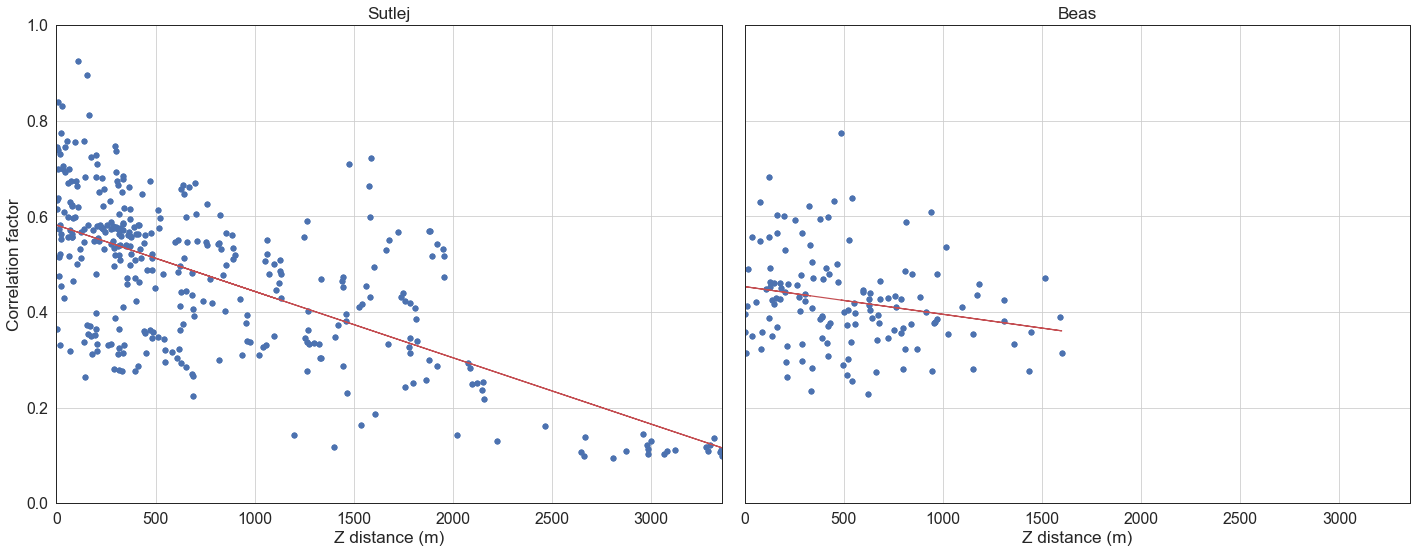

occurrence-['Z']


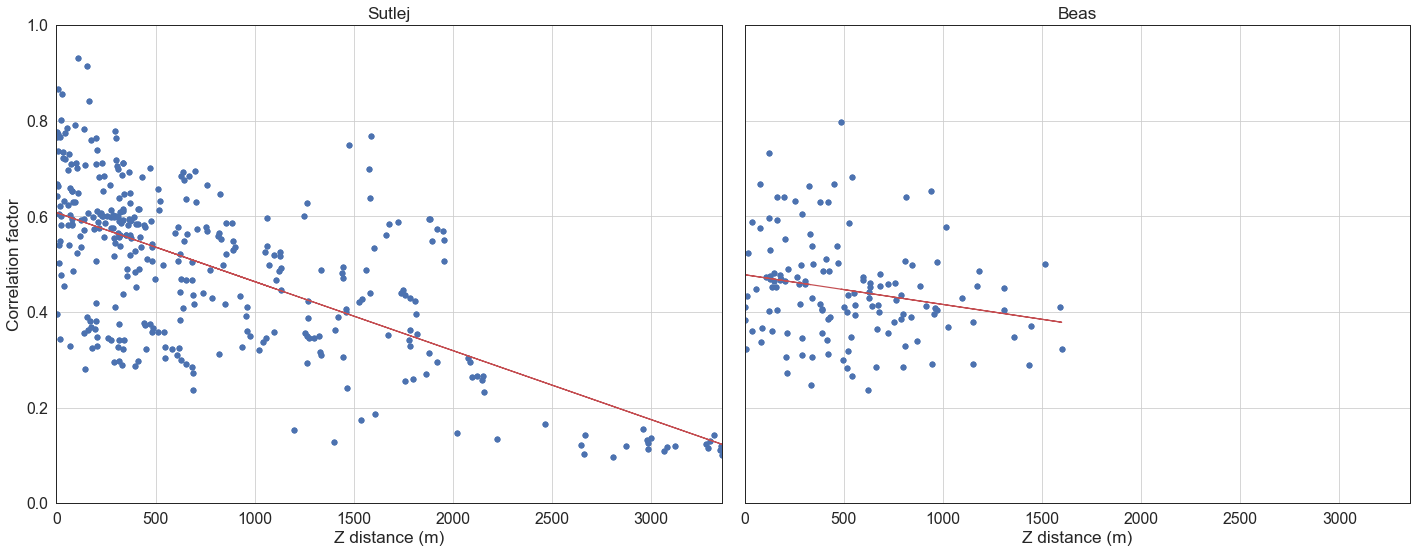

Prec-['Z']


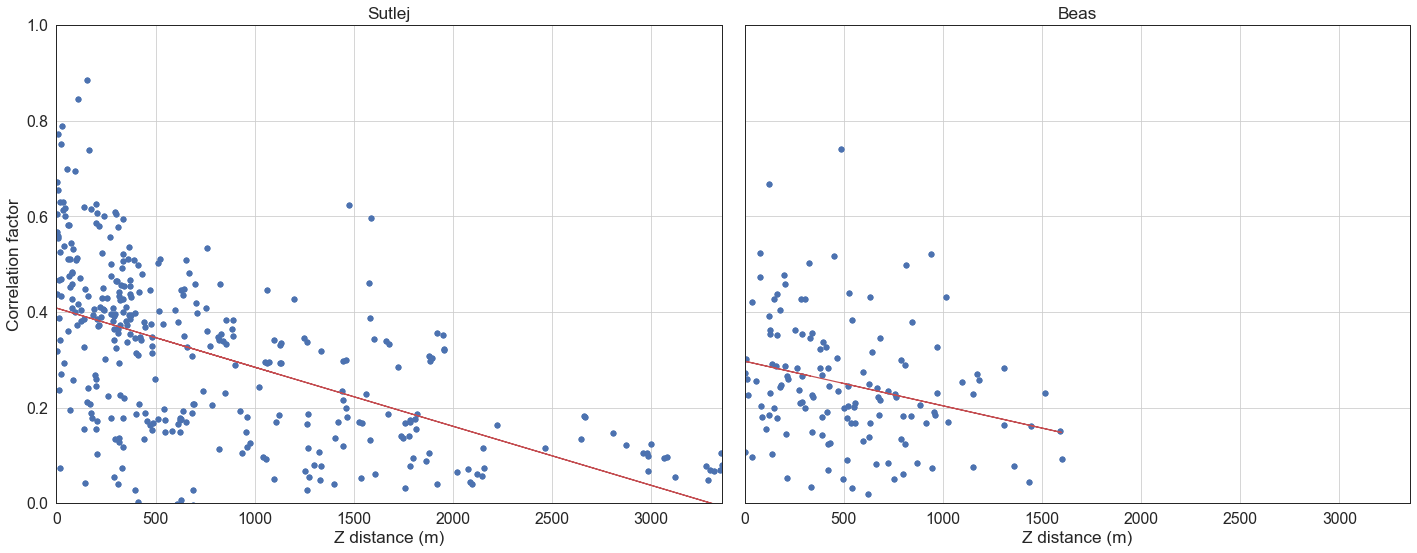

bias-['Z']


In [17]:
sns.set_theme(context='paper', style='white', font_scale=1.8)

dist_lists = [['X','Y'],['Z']]
corr_series_list = ['occurrence', 'Prec', 'bias']
show_reg_line = True

for dist_list in dist_lists:
    for corr_series in corr_series_list:
        correlation.plot_corr(st, corr_series, dist_list, show_reg_line=True, save_to_file=False, show=True)
#         correlation.plot_seasonal_corr(st, corr_series, dist_list, show_reg_line=True, save_to_file=True, show=False)
        print(f'{corr_series}-{dist_list}')

### Number of rain days per year

In [18]:
st['aspect_cat'] = st.apply(correlation.aspect_categories, axis=1)

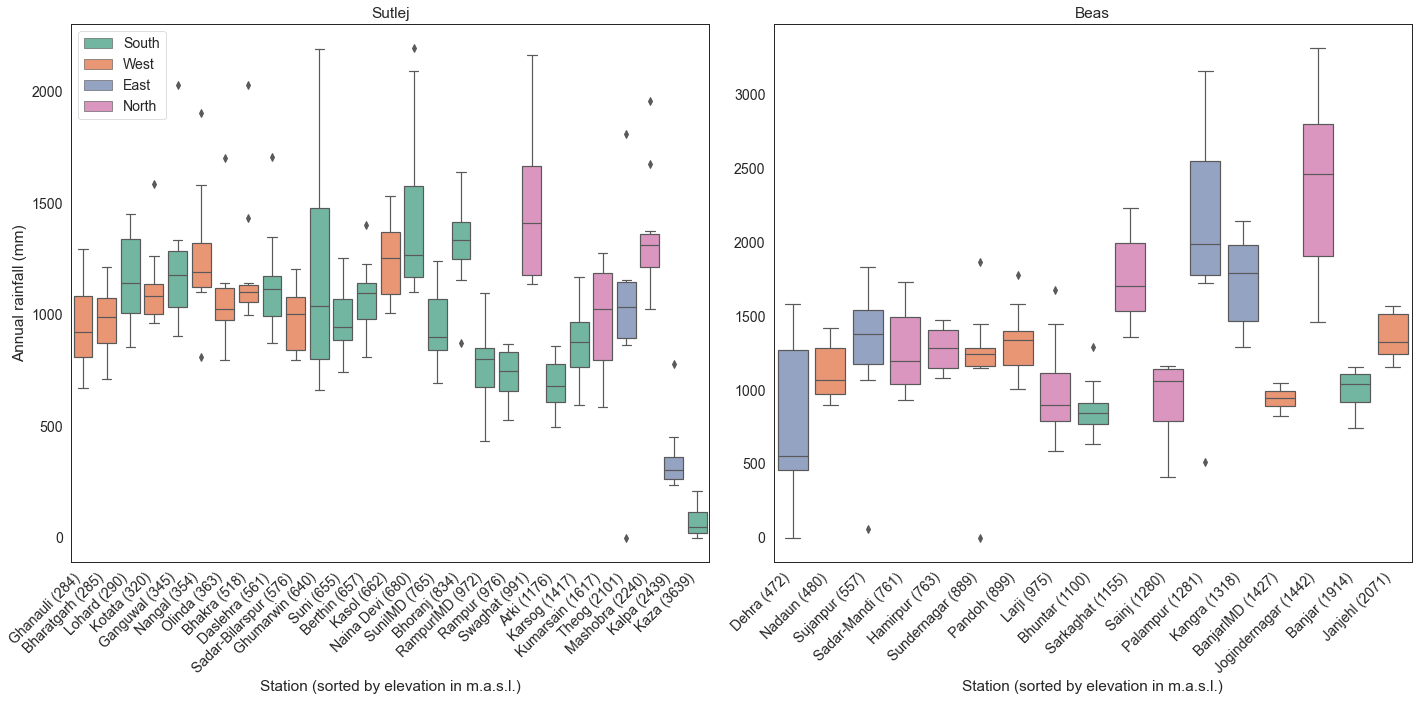

In [19]:
correlation.plot_annual_totals(st)

### Timeseries

In [2]:
# df_station['year'] = df_station.index.year
# df_station['month'] = df_station.index.month
# df_station['season'] = df_station.apply(season, axis=1)
# df_station['logPrec'] = df_station['Prec'].transform(lambda x: np.log(x + 0.001))

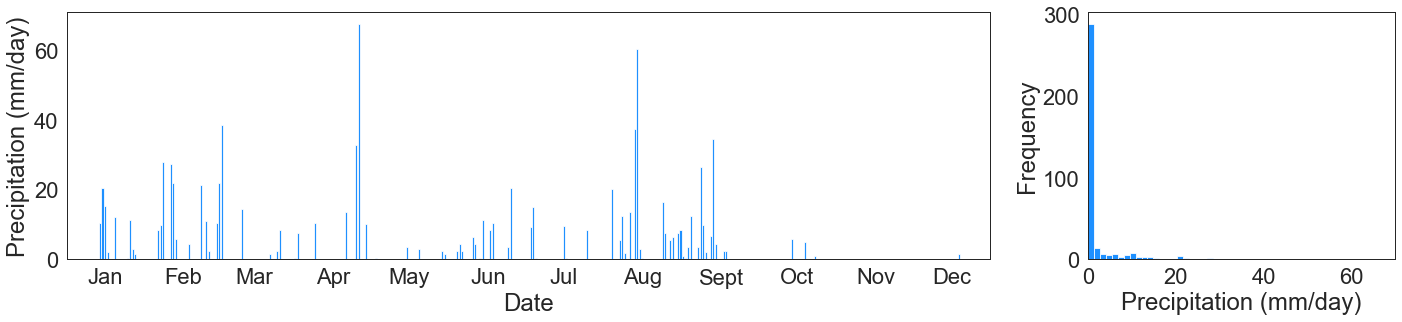

In [21]:
correlation.plot_daily_timeseries_and_frequency(st)

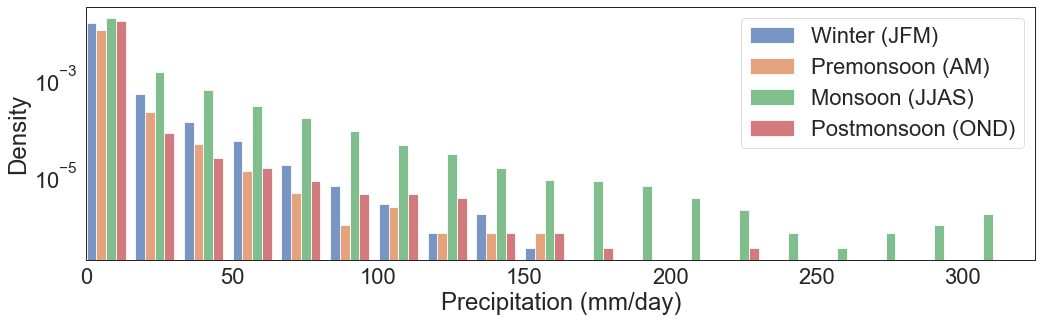

In [24]:
correlation.plot_seasonsal_intensity_histograms(st)

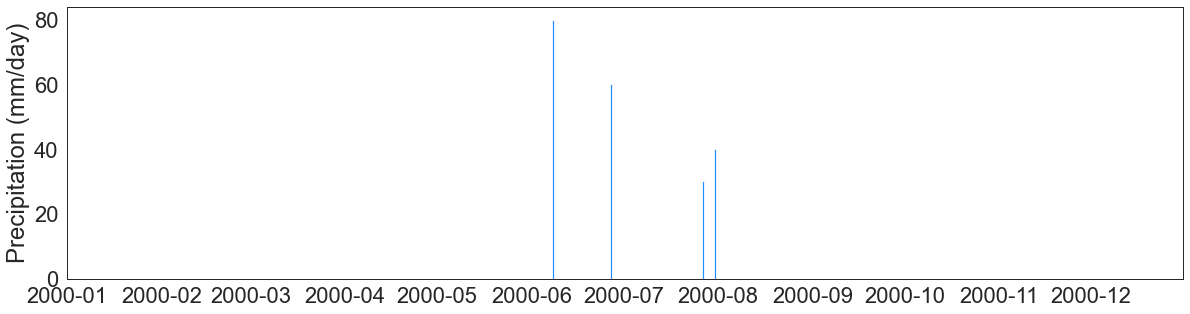

In [25]:
correlation.plot_timeseries_Kaza(st)

### ECDF

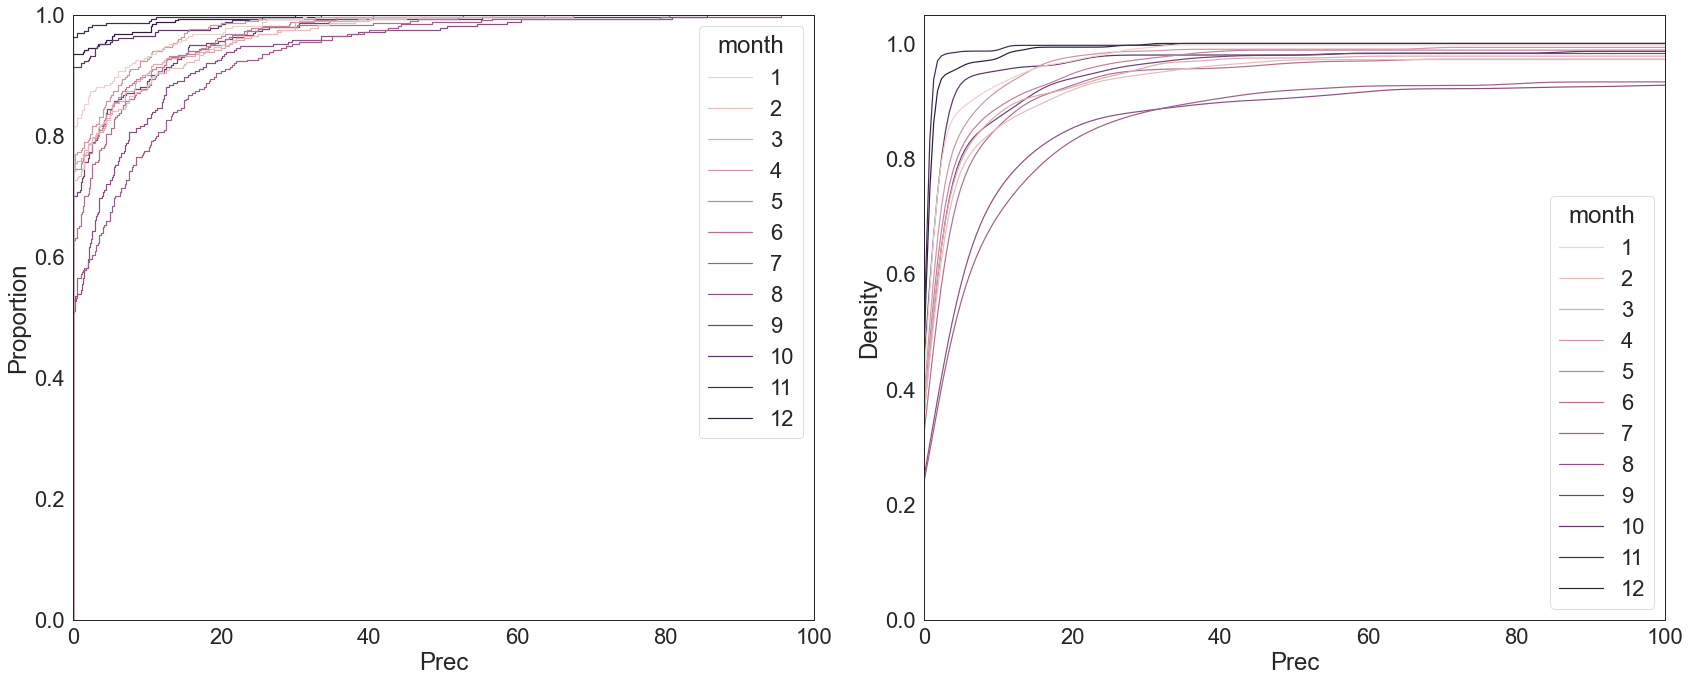

In [27]:
station = st['Station'].unique()[1]
df_station = st[st['Station']==station]
df_station.set_index('Date', inplace=True)

correlation.ecdf(df_station)

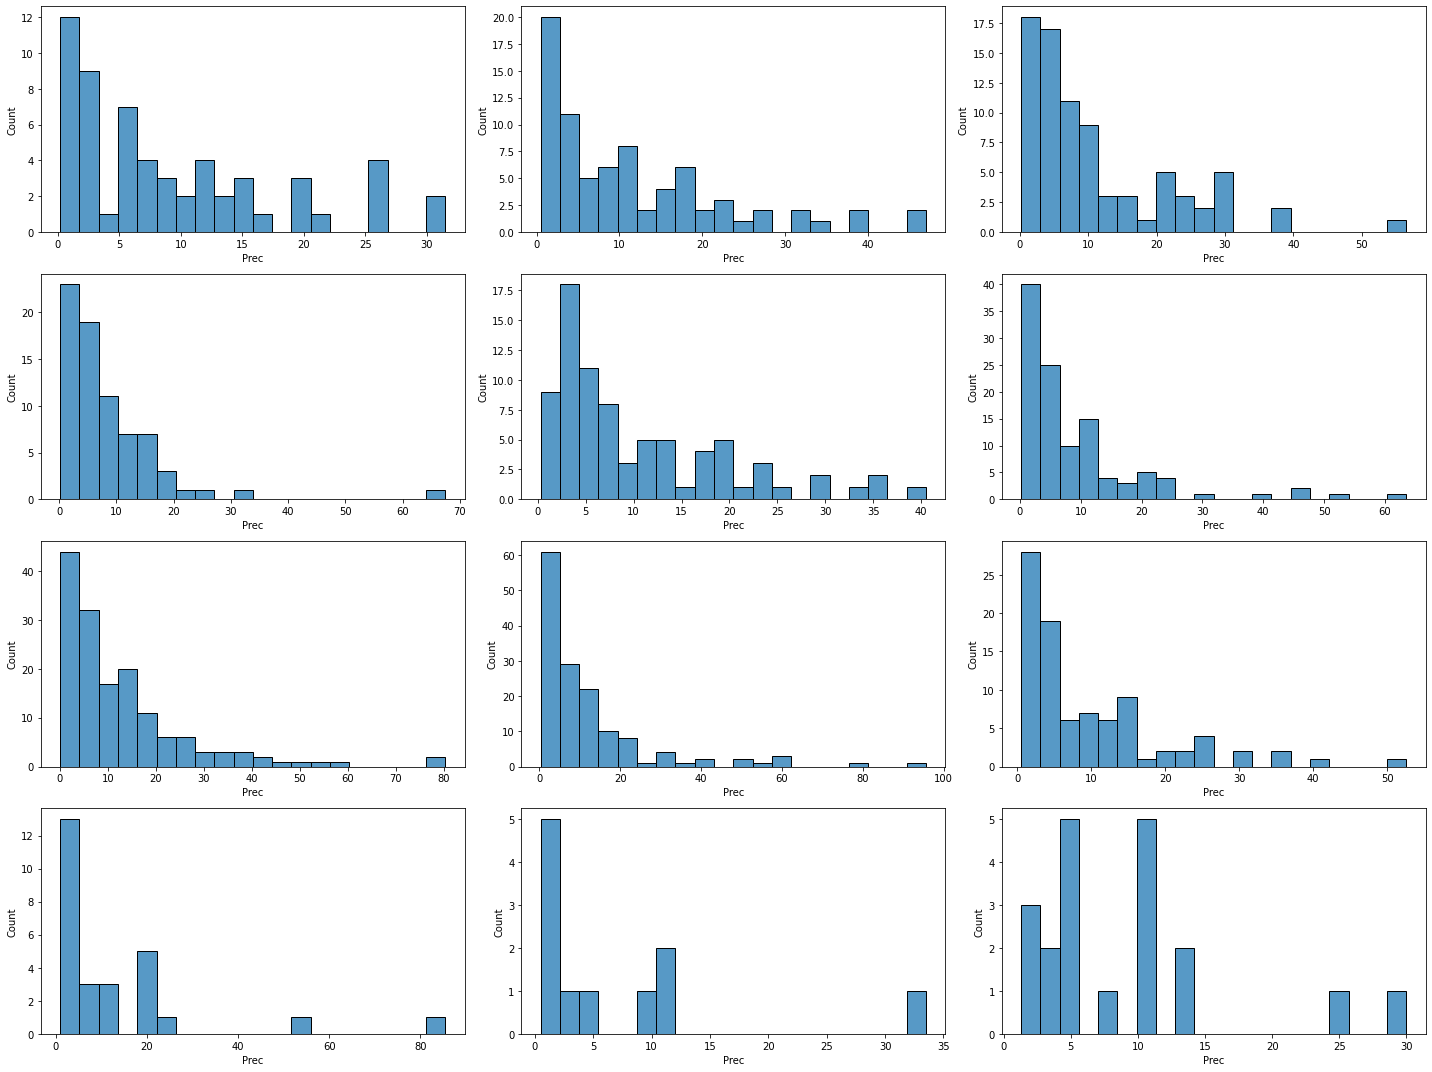

In [761]:
correlation.plot_monthly_histograms(df_station)

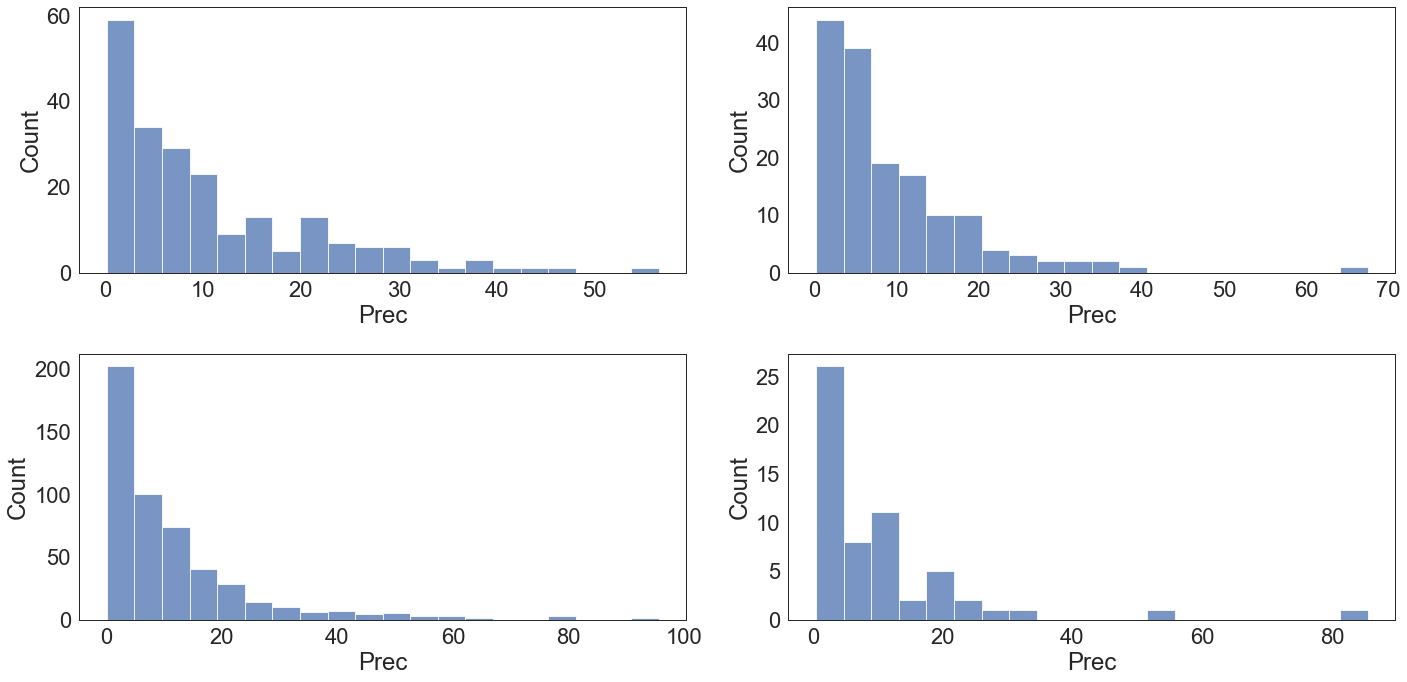

In [28]:
correlation.plot_seasonal_histograms(df_station)

### Autocorrelation

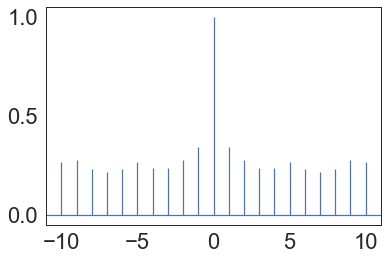

In [30]:
correlation.plot_autocorrelation(st)

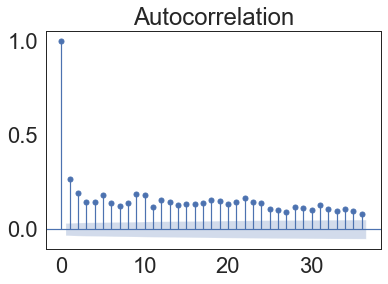

In [34]:
correlation.plot_autocorrelation_function(st)

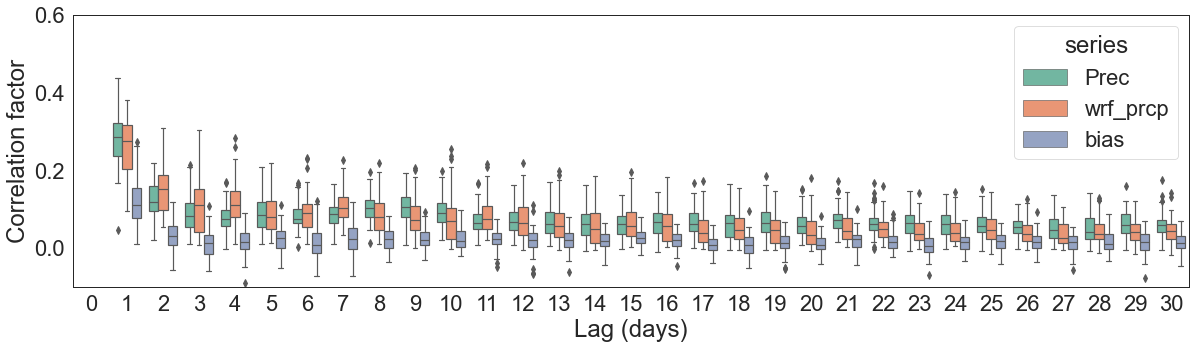

In [35]:
correlation.plot_acv_for_multiple_series(st)

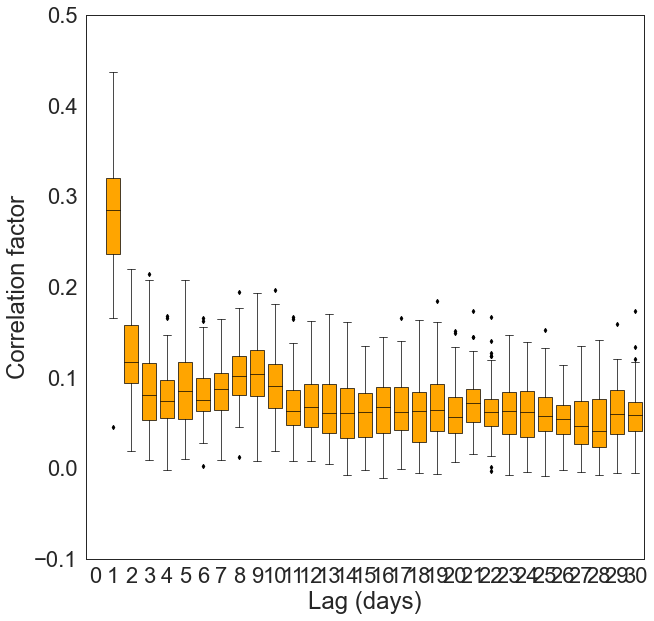

In [39]:
correlation.plot_acv(st)

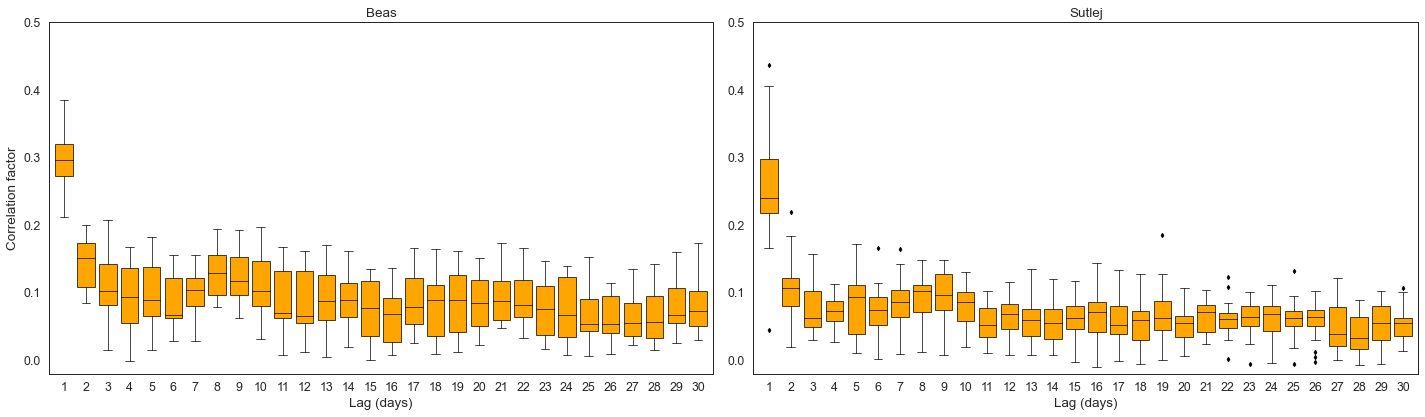

In [40]:
correlation.plot_acv_for_multiple_basins(st)

/Users/marron31/miniconda3/envs/upperindus/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:677: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[: nlags + 1] / avf[0]


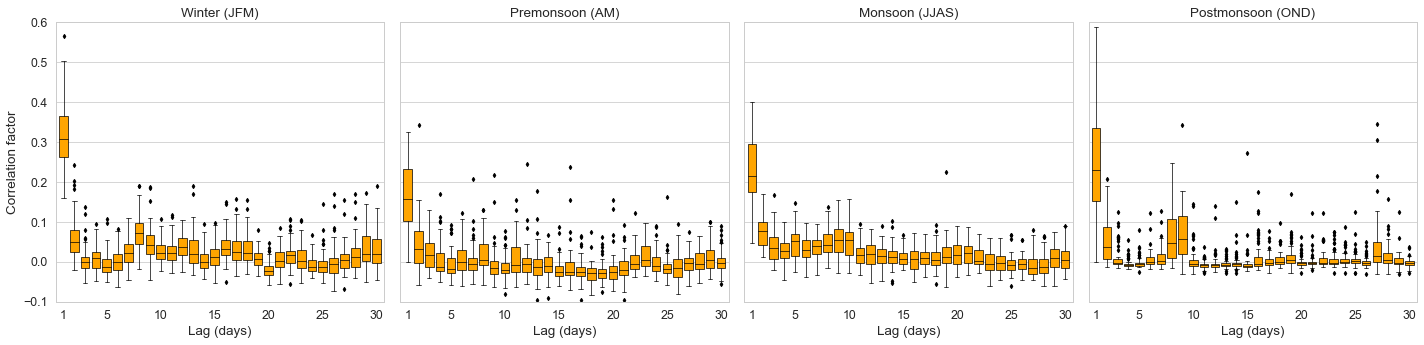

In [43]:
correlation.plot_acv_for_multiple_seasons(st)

### Quantile mapping

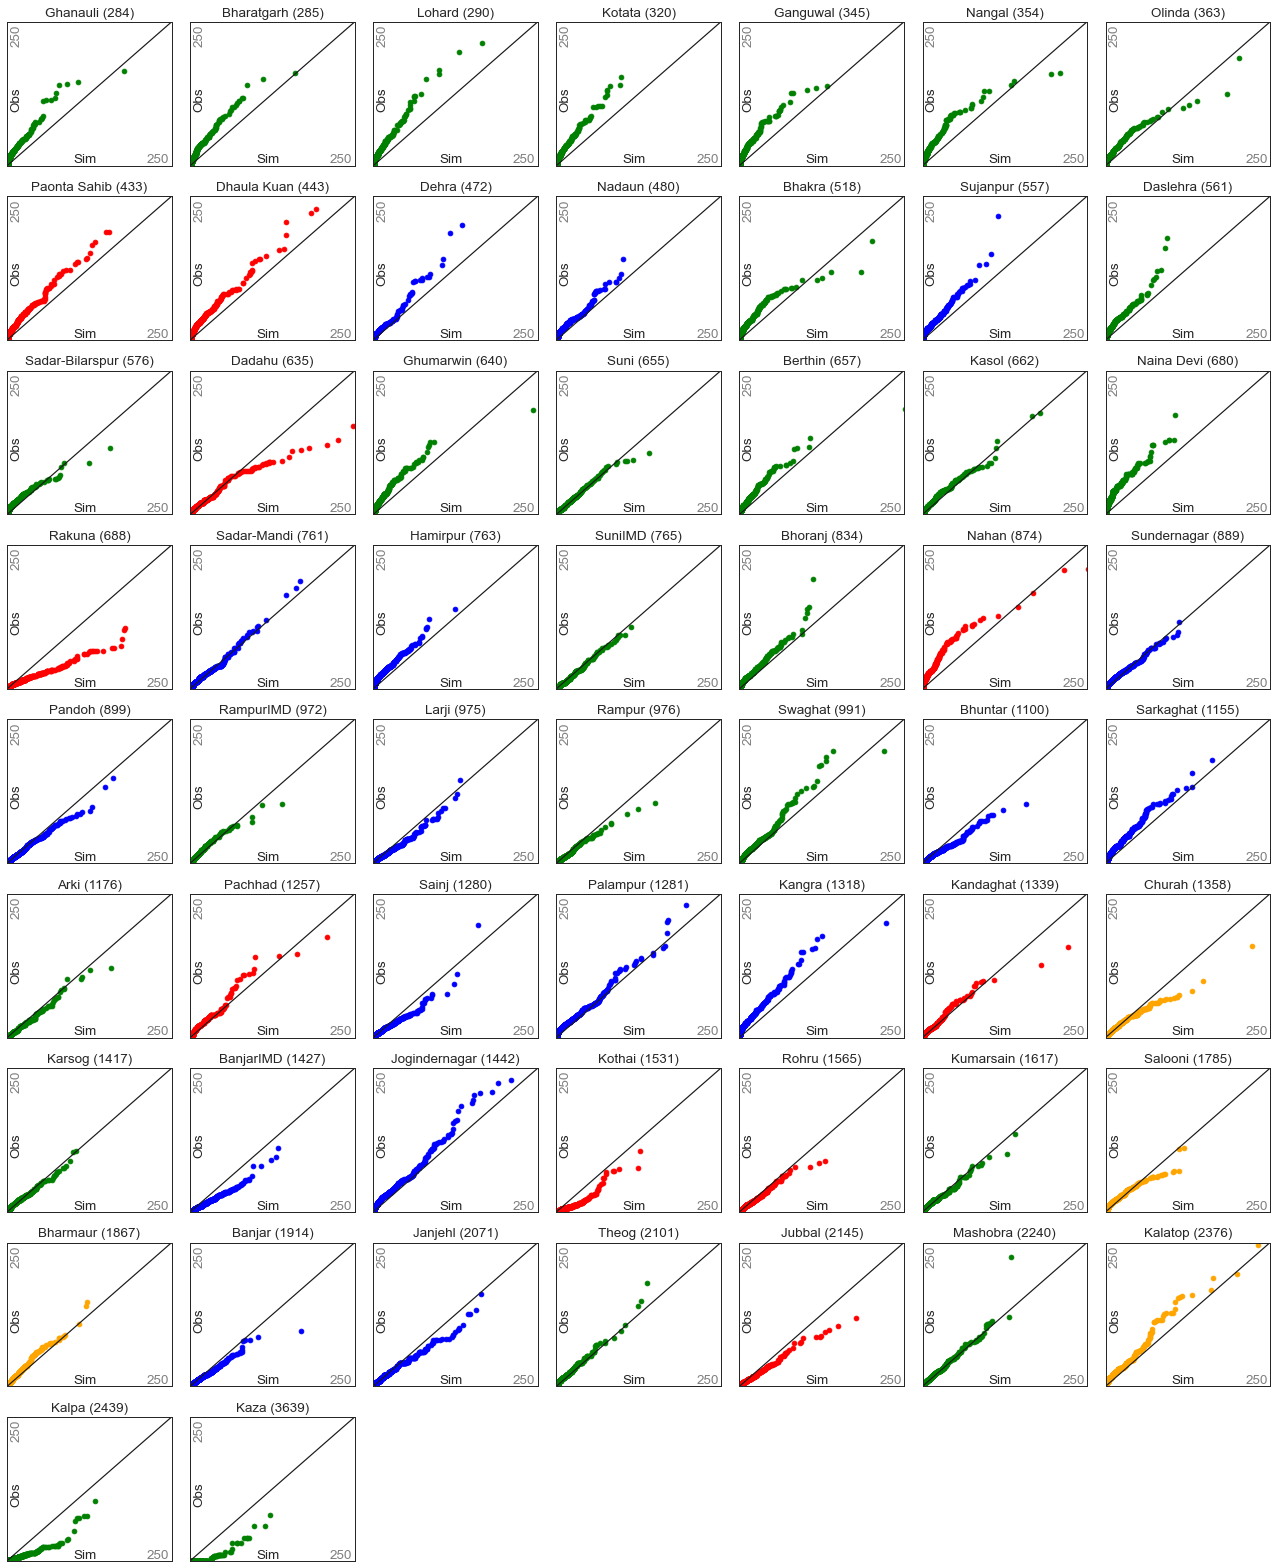

In [46]:
correlation.plot_qq_for_all_stations(st)